# Week 6

Patrick Weatherford

***


<br>

## Import Modules

Mount Google Drive to Colab session

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<br>Install necessary modules not pre-installed by Colab

In [2]:
%%capture
!pip install python-Levenshtein
!pip install fuzzywuzzy


<br>Copy custom packages/moduls over to default path where python packages are installed for this Colab session.

In [3]:
import os
import site
import shutil

# create custom modules folder in default pkg location
dest_path = site.getsitepackages()[0]  # get path where packages are installed
colab_cust_mod_path = f"{dest_path}/hakuna_patata_modules"

if not os.path.exists(colab_cust_mod_path):
    os.makedirs(colab_cust_mod_path)

# create init file in custom modules folder
with open(f"{colab_cust_mod_path}/__init__.py", 'w') as f:
    pass

mods = ['api_keys.py', 'hakuna_patata.py']  # modules to copy over

mod_path = r'/content/drive/MyDrive/Bellevue_University/Python/Custom_Modules'

for mod in mods:
    file_path = f"{mod_path}/{mod}"
    shutil.copy2(file_path, colab_cust_mod_path)


In [4]:
from hakuna_patata_modules import api_keys, hakuna_patata
from zipfile import ZipFile
import pandas as pd 
import numpy as np
from pandas import DataFrame as DF
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz
from IPython.display import Image
from google.colab.data_table import DataTable
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, f_classif
from sklearn import tree
from sklearn import set_config
def DT(df, num_rows_per_page=10):
    return DataTable(df, num_rows_per_page=num_rows_per_page)


***

<br>

## Part 1: PCA & Variance Threshold in Linear Regression

### Download & Import Data

In [5]:
kaggle_download_path = r'/content/kaggle_datasets'
kaggle_username = api_keys.Kaggle_API['username']
kaggle_api_key = api_keys.Kaggle_API['key']
kaggle_comp = 'house-prices-advanced-regression-techniques'
data_files = ['train.csv', 'test.csv', 'data_description.txt']

# Create Kaggle api object
kaggle_api = hakuna_patata.kaggle_api(kaggle_username, kaggle_api_key)

# Create directory for files to download to
if not os.path.exists(kaggle_download_path):
    os.makedirs(kaggle_download_path)

# Download data files from Kaggle
for data_file in data_files:
    kaggle_api.competition_download_file(competition=kaggle_comp, file_name=data_file, path=kaggle_download_path, force=True, quiet=True)


<br>

Create features/target sets.

In [6]:
train_df = pd.read_csv('kaggle_datasets/train.csv')

X = train_df.drop(['SalePrice'], axis=1)
y = train_df['SalePrice']

DT(X)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal


<br>

### Preparing Data for Modeling

Drop ID column and any columns missing > 40% of data.

In [7]:
null_percent = X.isna().sum() / len(X)  # total nulls divided by total observations
null_cols = null_percent[null_percent > .4]  # get columns where null % > 40%
drop_cols = list(null_cols.index)  # add columns to drop to list
drop_cols.append('Id')  # also include Id to drop

null_cols


Alley          0.937671
FireplaceQu    0.472603
PoolQC         0.995205
Fence          0.807534
MiscFeature    0.963014
dtype: float64

In [8]:
X_clean = X.drop(drop_cols, axis=1)

# Test to see that columns removed successfully
for col in drop_cols:
    try:
        X_clean[col]
        print(f"ERROR: {col} was not removed!")
    except:
        print(f"SUCCESS: {col} was removed!")


SUCCESS: Alley was removed!
SUCCESS: FireplaceQu was removed!
SUCCESS: PoolQC was removed!
SUCCESS: Fence was removed!
SUCCESS: MiscFeature was removed!
SUCCESS: Id was removed!


<br>

- For numeric data, impute median value.
- For categorical data, impute with class with highest frequency (mode).

In [9]:
numeric_cols = list(X_clean.select_dtypes(include='number').columns)
cat_cols = list(X_clean.select_dtypes(exclude='number').columns)

print(f"""
Numeric Columns: {len(numeric_cols)}
Categorical Columns: {len(cat_cols)}
""")



Numeric Columns: 36
Categorical Columns: 38



In [10]:
def fill_na(df):

    try:
        df = DF(df)
    except:
        print(f"Parameter must be convertible to DataFrame")

    numeric_cols = list(df.select_dtypes(include='number').columns)
    cat_cols = list(df.select_dtypes(exclude='number').columns)

    for col in numeric_cols:
        median = df[col].median()
        df[col] = df[col].fillna(median)

    for col in cat_cols:
        class_mode = df[col].mode()[0]
        df[col] = df[col].fillna(class_mode)

    return df

X_clean = fill_na(X_clean)
y_clean = fill_na(y)

feature_null_count = sum(X_clean.isna().sum())
target_null_count = sum(y_clean.isna().sum())

print(f"Total NaNs in Feature Set: {feature_null_count}")
print(f"Total NaNs in Target Set: {target_null_count}")


Total NaNs in Feature Set: 0
Total NaNs in Target Set: 0


<br>

Create Dummy Variables 

In [11]:
X_clean = pd.get_dummies(X_clean, prefix='dummy_', columns=cat_cols)

prepped_df_cols = X_clean.columns

prepped_df_cols


Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       ...
       'dummy__ConLw', 'dummy__New', 'dummy__Oth', 'dummy__WD',
       'dummy__Abnorml', 'dummy__AdjLand', 'dummy__Alloca', 'dummy__Family',
       'dummy__Normal', 'dummy__Partial'],
      dtype='object', length=270)

<br>

### Modeling

Crate Train/Test Data

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X_clean,
    y_clean,
    test_size=0.25,
    shuffle=True
)

print(f"""
Train Shape: {X_train.shape}
Test Shape: {X_test.shape}
""")



Train Shape: (1095, 270)
Test Shape: (365, 270)



<br>

Create Functions to Display Scores

In [13]:
def model_scores(y_actual, y_predicted, decimal=2):
    mse = mean_squared_error(y_actual, y_predicted, squared=True)
    rmse = mean_squared_error(y_actual, y_predicted, squared=False)
    r2 = r2_score(y_actual, y_predicted)



    if decimal is None or decimal is False:
        print(f"""
MSE: {mse}
RMSE: {rmse}
R\u00b2: {r2}
        """)

    else:
        print(f"""
MSE: {round(mse, decimal)}
RMSE: {round(rmse, decimal)}
R\u00b2: {round(r2, decimal)}
        """)

def cross_val_scores(estimator, X, y, cv=10, scoring=None):
    cv = cross_val_score(
        estimator,
        X,
        y,
        cv=10,
        scoring=None
    )

    print(f"""========================
CROSS VALIDATION
----------------

Average: {cv.mean()}

Values:
    """)
    pprint(cv)


<br>

Basic Linear Regression

> From the cross-validation analysis, it is apparent that the scores are very inconsistent. This is more than likely due to overfitting caused by "The Curse of Dimensionality!!!!". Or in layman's terms, we have WAY too many features.

In [14]:
pipe = Pipeline([
    ('ols', LinearRegression())
])

pipe.fit(X_train, y_train)

preds = pipe.predict(X_test)

rmse = mean_squared_error(y_test, preds, squared=False)
r2 = r2_score(y_test, preds)

model_scores(y_test, preds, decimal=2)
cross_val_scores(pipe, X_clean, y_clean, cv=10)
print(f"""
========================
PIPELINE INFO
-------------

Number of Features in Model: {pipe[-1].n_features_in_}
""")



MSE: 1.8267156814798915e+18
RMSE: 1351560461.64
R²: -269953352.4
        
CROSS VALIDATION
----------------

Average: -262758266.79026133

Values:
    
array([ 8.77017977e-01,  8.65846663e-01, -2.60535422e+09, -1.56556710e+04,
        9.04407048e-01,  6.79768364e-01,  8.84507120e-01,  8.97100679e-01,
       -2.22127970e+07,  9.03455725e-01])

PIPELINE INFO
-------------

Number of Features in Model: 270



PCA Analysis


> From the analysis, we have reduced our features and only 1 Principal Component (aka feature) was found to be of importance and retained over 99% of the variance in the data. After performing linear regression however, it is obvious that the model created does not explain the target well at all. This is probably because for feature reduction using PCA to work correctly, the data must be scaled first.

> On a positive note though, now that our features have been reduced, it would appear that the degree of overfitting has been lessened and our results are more consistent in our cross validation scores. 🙂 ⬅ Slightly Happy

In [15]:
pipe = Pipeline([
    ('pca', PCA(n_components=0.9, whiten=True)),
    ('ols', LinearRegression())
])

pipe.fit(X_train, y_train)

preds = pipe.predict(X_test)

rmse = mean_squared_error(y_test, preds, squared=False)
r2 = r2_score(y_test, preds)

model_scores(y_test, preds, decimal=2)
cross_val_scores(pipe, X_clean, y_clean, cv=10)
print(f"""
========================
PIPELINE INFO
-------------

Number of Features in Model: {pipe[-1].n_features_in_}
""")



MSE: 6928533030.73
RMSE: 83237.81
R²: -0.02
        
CROSS VALIDATION
----------------

Average: 0.032932835366818604

Values:
    
array([ 0.10281551,  0.04043344, -0.31527826,  0.08054181,  0.08768334,
        0.10931124,  0.0418991 ,  0.05883378,  0.05725768,  0.0658307 ])

PIPELINE INFO
-------------

Number of Features in Model: 1



<br>

PCA With Scaled Features

> Definitely looking better now. $R^2$ still only sitting at `0.55` but the results are much more consistent now. Also, because we normalized the data beforehand, the PCA worked much better and reduced our features from 270 to 25.

In [16]:
pipe = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('thresholder', VarianceThreshold(threshold=0.1)),
    ('pca', PCA(n_components=0.9, whiten=True)),
    ('ols', LinearRegression())
])

pipe.fit(X_train, y_train)

preds = pipe.predict(X_test)

rmse = mean_squared_error(y_test, preds, squared=False)
r2 = r2_score(y_test, preds)

model_scores(y_test, preds, decimal=2)
cross_val_scores(pipe, X_clean, y_clean, cv=10)
print(f"""
========================
PIPELINE INFO
-------------

Number of Features in Model: {pipe[-1].n_features_in_}
""")



MSE: 3098337855.78
RMSE: 55662.72
R²: 0.54
        
CROSS VALIDATION
----------------

Average: 0.5636551333818012

Values:
    
array([0.59893743, 0.56202771, 0.59336477, 0.49663282, 0.53460837,
       0.48680206, 0.57505461, 0.7089367 , 0.51674509, 0.56344176])

PIPELINE INFO
-------------

Number of Features in Model: 25



***

<br>

## Part 2: Categorical Feature Selection



### Download & Import Data

In [17]:
kaggle_dataset = r'uciml/mushroom-classification'
kaggle_file = r'mushroom.csv'

kaggle_api = hakuna_patata.kaggle_api(kaggle_username, kaggle_api_key)

hakuna_patata.kaggle_dataset_download(kaggle_api, kaggle_dataset, kaggle_download_path)


100%|██████████| 34.2k/34.2k [00:00<00:00, 5.63MB/s]


In [18]:
mushroom_df = DF()

with ZipFile(f"{kaggle_download_path}/mushroom-classification.zip") as zf:
    mushroom_df = pd.read_csv(zf.open('mushrooms.csv'))

DT(mushroom_df)


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


***

<br>

### Preparing Data for Modeling

In [19]:
dum_mushroom_df = pd.get_dummies(mushroom_df, prefix=[f"{col}" for col in mushroom_df.columns])

dum_mushroom_df = dum_mushroom_df.drop('class_e', axis=1)  # duplicative target. will keep class_p (1=poisonous; 0=edible)

DT(dum_mushroom_df)

Output hidden; open in https://colab.research.google.com to view.

<br>

### Modeling

Create Train/Test Data

In [20]:
features = dum_mushroom_df.drop('class_p', axis=1)
target = dum_mushroom_df[['class_p']]

X_train, X_test, y_train, y_test = train_test_split(
    features,
    target,
    train_size=0.3,
)

print(f"""
X_train shape: {X_train.shape}
X_test shape: {X_test.shape}
""")


X_train shape: (2437, 117)
X_test shape: (5687, 117)



Decision Tree Model 

I was actually very surprised by the results here which were very accurate. 

In [21]:
pipe = Pipeline([
    ('clf', tree.DecisionTreeClassifier())
])

pipe.fit(X_train, y_train)

preds = pipe.predict(X_test)

conf_matrix = confusion_matrix(y_test, preds, labels=pipe.classes_)

print(classification_report(y_test, preds))
print(f"{'='*50}\nCROSS_VALIDATION\n{'-'*30}")
cv = cross_val_score(pipe, features, target, cv=10, n_jobs=-1)
print(f"Average: {cv.mean()}\n")
print(f"Values: \n {cv}")
print(f"\n")


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2919
           1       1.00      1.00      1.00      2768

    accuracy                           1.00      5687
   macro avg       1.00      1.00      1.00      5687
weighted avg       1.00      1.00      1.00      5687

CROSS_VALIDATION
------------------------------
Average: 0.9564427195996098

Values: 
 [0.68511685 1.         1.         1.         0.99753695 1.
 1.         1.         0.8817734  1.        ]




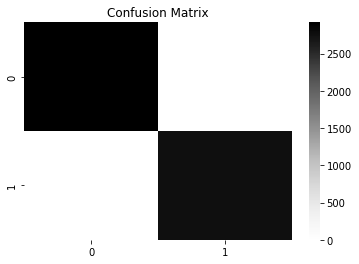

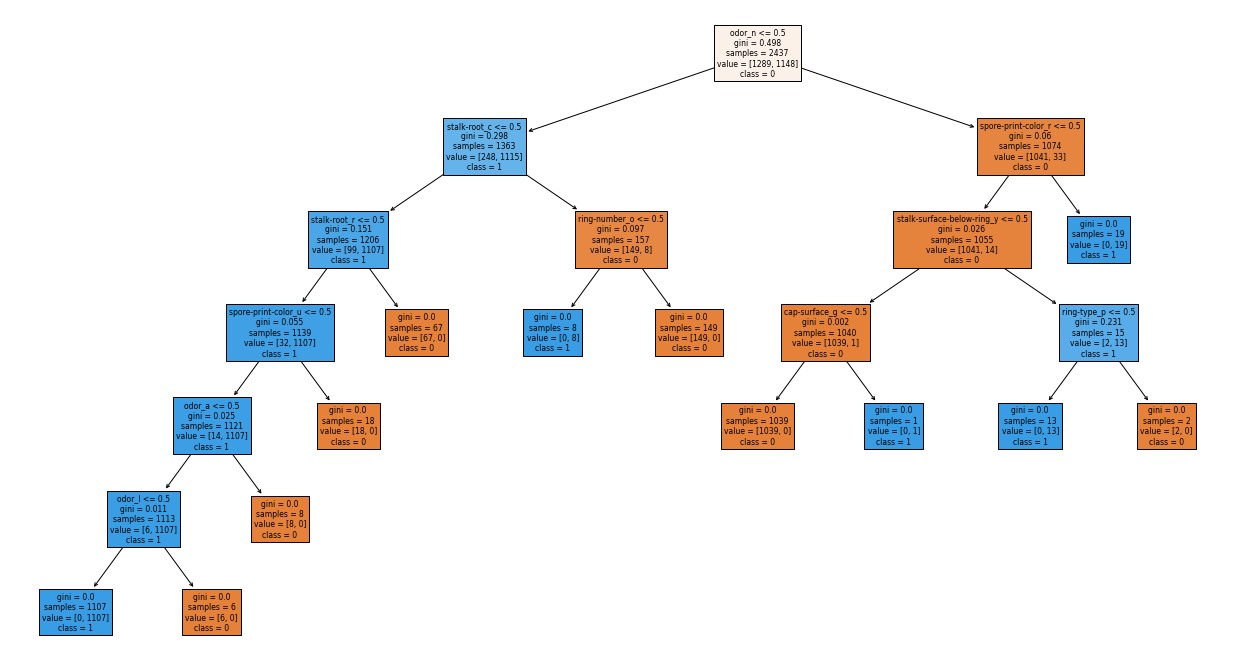

In [22]:
sns.heatmap(DF(conf_matrix), cmap='Greys')
plt.title('Confusion Matrix')
plt.show()

print('\n')

plt.figure(figsize=(22,12))
tree.plot_tree(pipe['clf'], filled=True, class_names=['0','1'], feature_names=X_test.columns.to_list())
plt.show()

In [23]:
pipe = Pipeline([
    ('feature_red', SelectKBest(chi2, k=5)),
    ('clf', tree.DecisionTreeClassifier())
])

pipe.fit(X_train, y_train)

features_selected = list(pipe['feature_red'].get_feature_names_out())

preds = pipe.predict(X_test)

conf_matrix = confusion_matrix(y_test, preds, labels=pipe.classes_)

print(f"FEATURES SELECTED:\n{features_selected}\n\n{'='*50}\nClassification Report\n")
print(classification_report(y_test, preds))
print(f"{'='*50}\nCROSS_VALIDATION\n{'-'*30}")
cv = cross_val_score(pipe, features, target, cv=10, n_jobs=-1)
print(f"Average: {cv.mean()}\n")
print(f"Values: \n {cv}")
print(f"\n")


FEATURES SELECTED:
['odor_f', 'odor_n', 'gill-color_b', 'stalk-surface-above-ring_k', 'stalk-surface-below-ring_k']

Classification Report

              precision    recall  f1-score   support

           0       0.88      1.00      0.93      2919
           1       1.00      0.85      0.92      2768

    accuracy                           0.93      5687
   macro avg       0.94      0.93      0.93      5687
weighted avg       0.94      0.93      0.93      5687

CROSS_VALIDATION
------------------------------
Average: 0.9017806397275795

Values: 
 [0.6199262  0.9495695  0.98523985 0.98646986 0.94211823 0.93719212
 0.92857143 0.91133005 0.91502463 0.84236453]




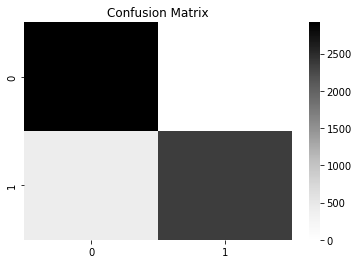

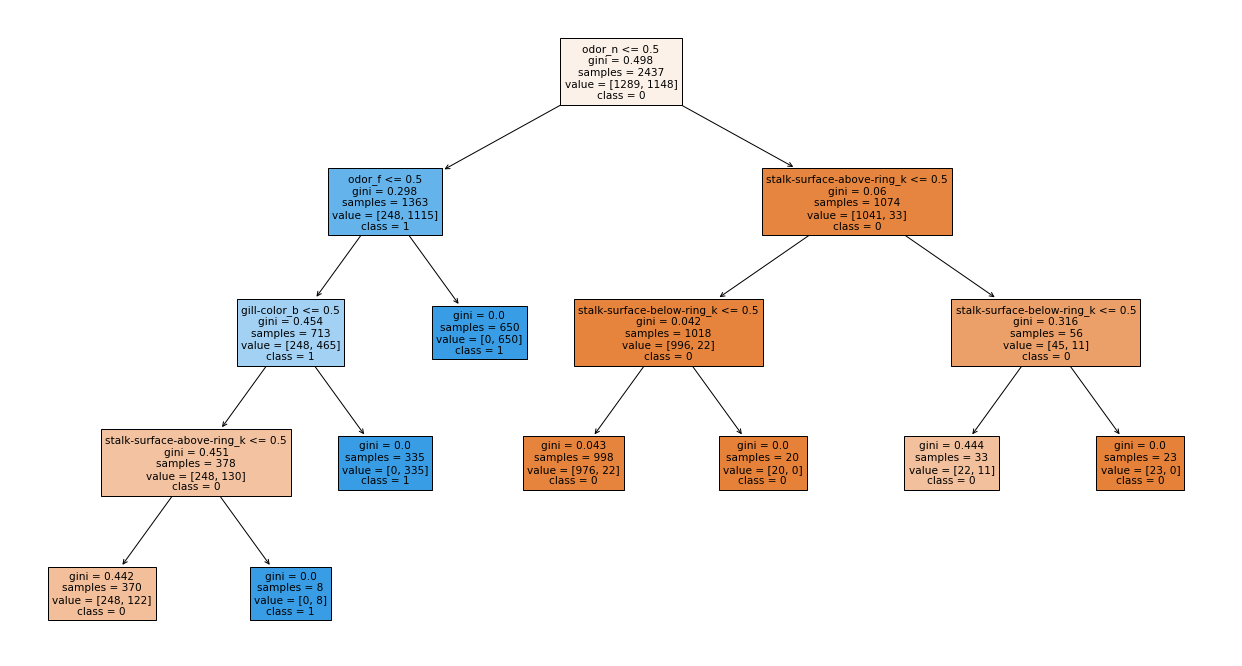

In [24]:
sns.heatmap(DF(conf_matrix), cmap='Greys')
plt.title('Confusion Matrix')
plt.show()

print('\n')

plt.figure(figsize=(22,12))
tree.plot_tree(pipe['clf'], filled=True, class_names=['0','1'], feature_names=features_selected)
plt.show()